# Imports

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d

# Helper Functions

In [77]:
def simple_k_fold(data, k):
    data = data.sample(frac=1).reset_index(drop=True)
    data['fold'] = np.tile(np.arange(k), len(data) // k + 1)[:len(data)]
    return data

In [78]:
def logsumexp(x, axis=None, keepdims=False):
    max_x = np.max(x, axis=axis, keepdims=True)
    log_sum_exp = np.log(np.sum(np.exp(x - max_x), axis=axis, keepdims=keepdims)) + max_x
    if not keepdims:
        log_sum_exp = np.squeeze(log_sum_exp, axis=axis)
    return log_sum_exp

In [79]:
def stratified_k_fold(data, k):
    data['fold'] = -1
    n_classes = data['class'].nunique()

    for i in range(n_classes):
        class_data = data[data['class'] == i]
        class_data = class_data.sample(frac=1).reset_index(drop=True)

        fold_sizes = np.full(k, len(class_data) // k, dtype=int)
        fold_sizes[:len(class_data) % k] += 1

        current = 0
        for fold, fold_size in enumerate(fold_sizes):
            start, stop = current, current + fold_size
            class_data.loc[start:stop-1, 'fold'] = fold
            current = stop

        data.loc[data['class'] == i] = class_data

    return data


In [80]:
def create_interleaved_folds(dataset, k):
    # Shuffle the dataset
    dataset = dataset.sample(frac=1).reset_index(drop=True)

    # Divide the dataset into k subsets of approximately equal size
    subsets = np.array_split(dataset, k)

    # Create a new DataFrame with interleaved samples from the subsets
    interleaved_data = pd.DataFrame(columns=dataset.columns)
    for i in range(len(subsets[0])):
        for subset in subsets:
            if i < len(subset):
                interleaved_data = pd.concat([interleaved_data, subset.iloc[[i]]], ignore_index=True)

    # Assign fold numbers to the samples
    interleaved_data['fold'] = [i % k for i in range(len(interleaved_data))]

    return interleaved_data


In [81]:
def auc(fpr, tpr):
    area = np.trapz(tpr, fpr)
    return area

In [82]:
def confusion_matrix(y_true, y_pred, class_names=None):
    if class_names is None:
        class_names = np.unique(np.concatenate((y_true, y_pred)))

    matrix = np.zeros((len(class_names), len(class_names)), dtype=int)

    class_name_to_index = {name: index for index, name in enumerate(class_names)}

    for t, p in zip(y_true, y_pred):
        matrix[class_name_to_index[t], class_name_to_index[p]] += 1

    return matrix


In [83]:
def compute_tpr_fpr(cm):
    tp = cm[1][1]
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]

    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)

    return tpr, fpr

# Gaussian Naive Bayes

In [84]:
class GaussianNaiveBayes:
    def __init__(self):
        self.classes = None
        self.parameters = []

    def fit(self, X, y):
        # find unique classes in the labels
        self.classes = np.unique(y)
        self.parameters = []

        # for each class, compute the mean and standard deviation of the features for the samples belonging to that class
        for c in self.classes:
            X_c = X[y == c]
            mean = np.mean(X_c, axis=0)
            std = np.std(X_c, axis=0)
            self.parameters.append((mean, std))

    def print_parameters(self):
        for i, c in enumerate(self.classes):
            print('Class {}: mean = {}, std = {}'.format(c, self.parameters[i][0], self.parameters[i][1]))

    def _prob(self, x, mean, std):
        # compute Gaussian probability density function
        exponent = np.exp(-((x - mean)**2 / (2 * std**2)))
        return exponent / (np.sqrt(2 * np.pi) * std)


    def predict(self, X):
        n_samples = X.shape[0]
        y_pred = np.empty(n_samples)

        # for each sample in X, compute the posterior probability of each class
        for i, sample in enumerate(X):
            posteriors = []

            for mean, std in self.parameters:
                # assume equal prior probability for all classes
                prior = np.log(1/len(self.classes))
                # compute the sum of log probabilities for each feature
                posterior = np.sum(np.log(self._prob(sample, mean, std))) + prior
                posteriors.append(posterior)

            # choose the class with the highest posterior probability
            y_pred[i] = self.classes[np.argmax(posteriors)]

        return y_pred


    def _calculate_log_likelihoods(self, X):
        n_classes = len(self.classes)
        n_features = X.shape[1]
        log_likelihoods = np.zeros((X.shape[0], n_classes))

        for i in range(n_classes):
            mean, std = self.parameters[i]
            log_likelihood = -0.5 * np.sum(((X - mean) / std) ** 2, axis=1) - np.log(np.prod(std))
            prior = np.log(1 / n_classes)  # Assuming equal prior probabilities for all classes
            log_likelihoods[:, i] = log_likelihood + prior

        return log_likelihoods



    def predict_prob(self, X):
        scores = self._calculate_log_likelihoods(X)
        probabilities = np.exp(scores - logsumexp(scores, axis=1, keepdims=True))
        return probabilities
    
    def compute_roc_curve(self, X_test, y_test, n_thresholds=100):
        # Get the probability estimates for each data point in X_test
        probs = self.predict_prob(X_test)

        # Compute the true positive rate (TPR) and false positive rate (FPR) at different thresholds
        thresholds = np.linspace(0, 1, n_thresholds)
        tprs = np.zeros(n_thresholds)
        fprs = np.zeros(n_thresholds)
        eps = 1e-10

        for i, threshold in enumerate(thresholds):
            # Get predictions by thresholding the probabilities
            y_pred = (probs[:, 1] >= threshold).astype(int)

            # Compute confusion matrix
            cm = confusion_matrix(y_test, y_pred)

            # Calculate TPR and FPR
            tpr = cm[1, 1] / (cm[1, 1] + cm[1, 0] + eps)
            fpr = cm[0, 1] / (cm[0, 1] + cm[0, 0] + eps)

            tprs[i] = tpr
            fprs[i] = fpr

        return fprs, tprs

In [85]:
def run_cross_validation(dataset, k=10, verbose=False, show_cm=False, plot_roc=False, interleave=True):
    if interleave:
        dataset = create_interleaved_folds(dataset, k)
    else:
        dataset = stratified_k_fold(dataset, k)
    metrics = []
    tprs = []
    fprs = []

    base_fpr = np.linspace(0, 1, 101)  # Create a common set of FPR values

    for fold in range(k):
        train_data = dataset[dataset['fold'] != fold]
        test_data = dataset[dataset['fold'] == fold]

        X_train = train_data.drop(columns=['class', 'fold']).values
        y_train = train_data['class'].values

        X_test = test_data.drop(columns=['class', 'fold']).values
        y_test = test_data['class'].values

        class_names = np.unique(y_test)

        # Train the Gaussian Naive Bayes classifier
        gnb = GaussianNaiveBayes()
        gnb.fit(X_train, y_train)

        # Compute ROC curve for the current fold
        fold_fprs, fold_tprs = gnb.compute_roc_curve(X_test, y_test)
        
        # Interpolate TPR values to the common set of FPR values
        interp_tpr = interp1d(fold_fprs, fold_tprs, kind='linear', fill_value=(0, 1), bounds_error=False)(base_fpr)
        tprs.append(interp_tpr)
        fprs.append(fold_fprs)

        if plot_roc:
            # print(f"Fold {fold}: FPR = \n{fold_fprs},\n TPR = \n{fold_tprs}, \ninterp_TPR = \n{interp_tpr},\n AUC = \n{auc(fold_fprs, fold_tprs)}")
            # plt.figure()
            plt.plot(fold_fprs, fold_tprs, alpha=0.3, label=f"Fold {fold}")

        # Test the classifier
        y_pred = gnb.predict(X_test)

        # Calculate performance metrics
        cm = confusion_matrix(y_test, y_pred, class_names=class_names)
        accuracy = (cm[0, 0] + cm[1, 1]) / np.sum(cm)
        precision = cm[0, 0] / (cm[0, 0] + cm[1, 0])
        recall = cm[0, 0] / (cm[0, 0] + cm[0, 1])
        f1 = 2 * (precision * recall) / (precision + recall)

        if verbose:
            print(f"Fold {fold} - Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-score: {f1:.2f}")

            if show_cm:
                plt.figure()
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
                plt.xlabel('Predicted')
                plt.ylabel('True')
                plt.title(f'Confusion Matrix - Fold {fold}')
                plt.show()
        metrics.append((accuracy, precision, recall, f1))

    mean_tprs = np.mean(tprs, axis=0).flatten()
    auc_score = auc(base_fpr, mean_tprs)
    # print(fprs)
    # print(tprs)
    if plot_roc:
        plt.plot(base_fpr, mean_tprs, 'b', label=f"Mean ROC (AUC = {auc_score:.2f})", linewidth=2)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves per Fold and Mean ROC')
        plt.legend(loc='lower right')
        plt.show()

    return metrics, fprs, tprs, auc_score


# Dataset Manipulation

In [86]:
data = pd.read_csv('iris.tmls')
data = data.drop(data.index[0])

# Identify unique classes and assign integer labels
unique_classes = data.iloc[:, -1].unique()
class_mapping = {c: i for i, c in enumerate(unique_classes)}
data.iloc[:, -1] = data.iloc[:, -1].apply(lambda x: class_mapping[x])

# Convert the rest of the DataFrame to float64 values
data = data.astype(np.float64)

print("Data types after conversion:", data.dtypes)
print("Check if it's equal to np.float64:", data.iloc[:, -2].dtype == np.float64)


Data types after conversion: sepal length    float64
sepal width     float64
petal length    float64
petal width     float64
class           float64
dtype: object
Check if it's equal to np.float64: True


C:\Users\kirik\AppData\Local\Temp\ipykernel_17448\2447774568.py:7: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.iloc[:, -1] = data.iloc[:, -1].apply(lambda x: class_mapping[x])


In [87]:
# Split the dataset into features and labels
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values
classes = np.unique(y)

In [88]:
# Creating 3 datasets. removing 1 class from the main dataset each time
datasets = []

for i in range(len(classes)):
    # reset index
    temp = data[data['class'] != classes[i]]
    temp = temp.reset_index(drop=True)
    datasets.append(temp)


# Dataset 0
## Iris-versicolor and Iris-virginica

In [89]:
dataset_0 = datasets[0]

Fold 0 - Accuracy: 0.90, Precision: 1.00, Recall: 0.75, F1-score: 0.86
Fold 1 - Accuracy: 0.90, Precision: 0.86, Recall: 1.00, F1-score: 0.92
Fold 2 - Accuracy: 0.90, Precision: 1.00, Recall: 0.80, F1-score: 0.89
Fold 3 - Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1-score: 1.00
Fold 4 - Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1-score: 1.00
Fold 5 - Accuracy: 0.80, Precision: 0.83, Recall: 0.83, F1-score: 0.83
Fold 6 - Accuracy: 0.90, Precision: 0.83, Recall: 1.00, F1-score: 0.91
Fold 7 - Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1-score: 1.00
Fold 8 - Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1-score: 1.00
Fold 9 - Accuracy: 0.90, Precision: 0.80, Recall: 1.00, F1-score: 0.89


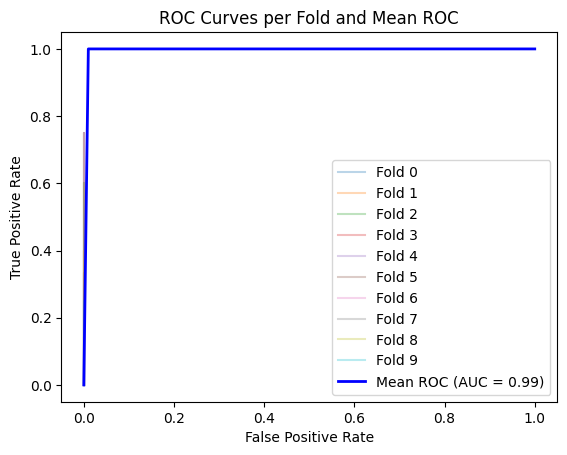

In [90]:
metric_0, fprs_0, tprs_0, auc_0 = run_cross_validation(dataset_0, k=10, verbose=True, plot_roc=True)

In [91]:
metric_0, fprs_0, tprs_0, auc_0 = run_cross_validation(dataset_0, k=10, verbose=True, plot_roc=True, interleave=False)


IndexError: index 1 is out of bounds for axis 0 with size 1

# Dataset 1
## Iris-setosa and Iris-virginica

Fold 0 - Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1-score: 1.00
Fold 1 - Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1-score: 1.00
Fold 2 - Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1-score: 1.00
Fold 3 - Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1-score: 1.00
Fold 4 - Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1-score: 1.00
Fold 5 - Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1-score: 1.00
Fold 6 - Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1-score: 1.00
Fold 7 - Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1-score: 1.00
Fold 8 - Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1-score: 1.00
Fold 9 - Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1-score: 1.00


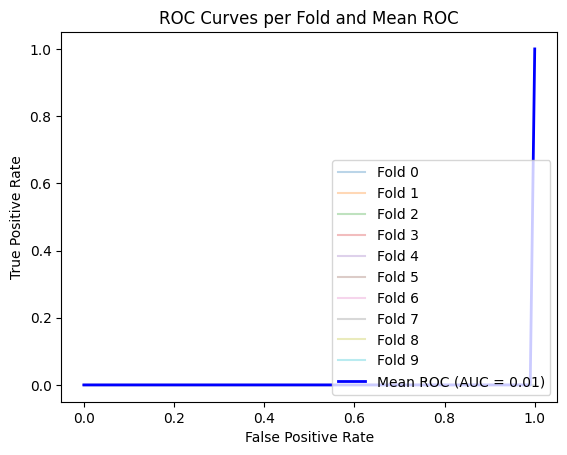

In [ ]:
dataset_1 = datasets[1]
metric_1, fprs_1, tprs_1, auc_1 = run_cross_validation(dataset_1, k=10, verbose=True, plot_roc=True)

Fold 0 - Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1-score: 1.00
Fold 1 - Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1-score: 1.00
Fold 2 - Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1-score: 1.00
Fold 3 - Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1-score: 1.00
Fold 4 - Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1-score: 1.00
Fold 5 - Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1-score: 1.00
Fold 6 - Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1-score: 1.00
Fold 7 - Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1-score: 1.00
Fold 8 - Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1-score: 1.00
Fold 9 - Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1-score: 1.00


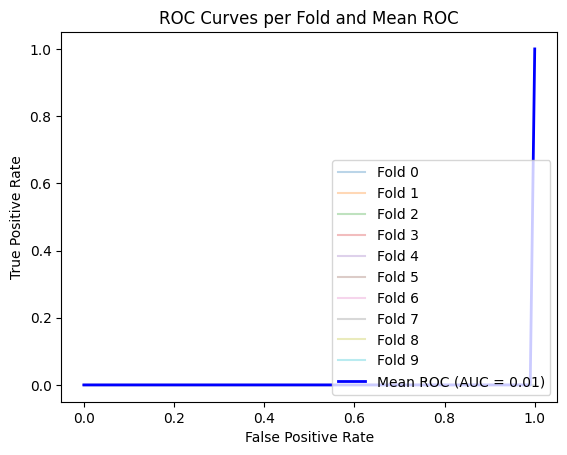

In [ ]:
metric_1, fprs_1, tprs_1, auc_1 = run_cross_validation(dataset_1, k=10, verbose=True, plot_roc=True, interleave=False)

# Dataset 2
## Iris-setosa and Iris-versicolor

Fold 0 - Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1-score: 1.00
Fold 1 - Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1-score: 1.00
Fold 2 - Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1-score: 1.00
Fold 3 - Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1-score: 1.00
Fold 4 - Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1-score: 1.00
Fold 5 - Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1-score: 1.00
Fold 6 - Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1-score: 1.00
Fold 7 - Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1-score: 1.00
Fold 8 - Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1-score: 1.00
Fold 9 - Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1-score: 1.00


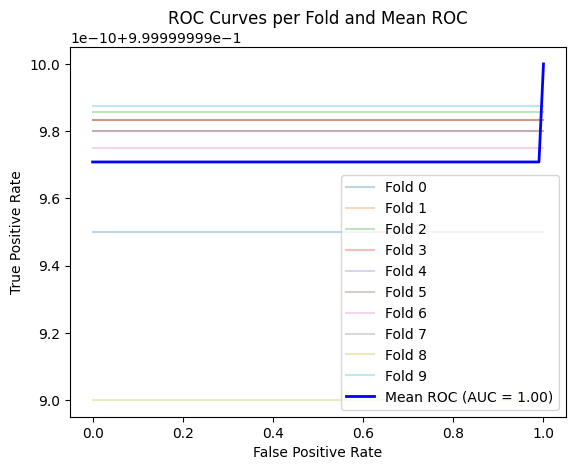

In [ ]:
dataset_2 = datasets[2]
metric_2, fprs_2, tprs_2, auc_2 = run_cross_validation(dataset_2, k=10, verbose=True, plot_roc=True)

Fold 0 - Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1-score: 1.00
Fold 1 - Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1-score: 1.00
Fold 2 - Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1-score: 1.00
Fold 3 - Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1-score: 1.00
Fold 4 - Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1-score: 1.00
Fold 5 - Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1-score: 1.00
Fold 6 - Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1-score: 1.00
Fold 7 - Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1-score: 1.00
Fold 8 - Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1-score: 1.00
Fold 9 - Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1-score: 1.00


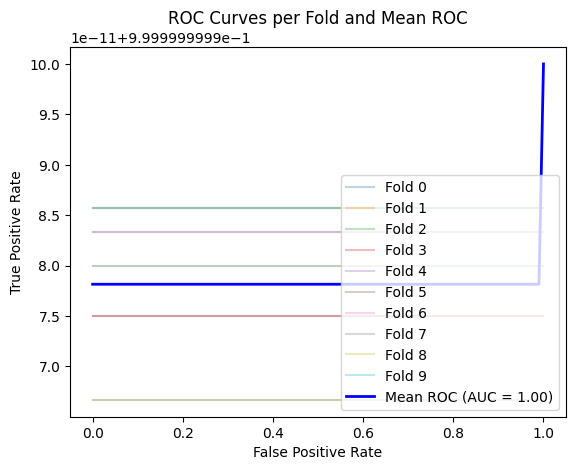

In [ ]:
metric_2, fprs_2, tprs_2, auc_2 = run_cross_validation(dataset_2, k=10, verbose=True, plot_roc=True, interleave=False)